In [2]:
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import skbio
# from skbio import diversity
# from skbio.stats import ordination
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist

## Read data

In [2]:
otus = pd.read_csv("../data/otus.csv")
comp = pd.read_csv("../data/comp.csv")

In [7]:
otus.sequence.str.len().value_counts().head()

251    33315
252     2644
250      538
253      202
254       30
Name: sequence, dtype: int64

## Prepare OTU-sample table and sequences for phylogenetic tree

In [72]:
def get_silva_taxonomy(taxa_raw: list):
    domain = None
    for i in range(len(taxa_raw)):
        if taxa_raw[i].startswith("\tsilva"):
            domain = taxa_raw[i].split("|")[-1]
            break
    taxa = {"domain": domain}
    tunits = ["phylum", "class", "order", "family", "genus"]
    for unit in tunits:
        taxa[unit] = None
    for unit, value in zip(tunits, taxa_raw[i + 1:]):
        taxa[unit] = value
    return taxa

In [99]:
otus_taxa = pd.DataFrame(otus.taxonomy.str.split("&").apply(get_silva_taxonomy).tolist())
otus_full = pd.concat([otus, otus_taxa], axis=1)
otus_core = otus_full[["domain", "phylum", "class", "order", "family", "genus", "sequence"]]
print(otus_core.shape)
otus_core = otus_core.drop_duplicates(["domain", "phylum", "class", "order", "family", "genus"])
otus_core["OTU"] = np.arange(1, otus_core.shape[0] + 1)
otus_core["OTU"] = otus_core["OTU"].apply(lambda x: f"OTU_{x}")
print(otus_core.shape)
otus_core.head()

(36834, 7)
(1257, 8)


,domain,phylum,class,order,family,genus,sequence,OTU
0,Bacteria,Caldatribacteriota,JS1,None,None,None,TACATAAGGAGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCT...,OTU_1
7,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
9,Bacteria,Actinobacteriota,Thermoleophilia,Gaiellales,Gaiellaceae,Gaiella,TACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGCG...,OTU_3
14,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
16,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,None,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [108]:
comp_full = pd.merge(comp, otus_core, "left", on=["domain", "phylum", "class", "order", "family", "genus"])
comp_full

,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0.00000,0.0114,0.00000,0.00000,0.00000,0.00920,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,S-BQ2-57 soil group,NaN,NaN,TACGGAGACGGCAAGCGTTGCTCGGAATCATTGGGCGTAAAGGGTC...,OTU_737
1402,0.00560,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Rubritaleaceae,Persicirhabdus,TACGAAGGTCCCGAGCGTTATTCGGAATCACTGGGCGTAAAAAGTA...,OTU_794
1403,0.00560,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,uncultured,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGTG...,OTU_620
1404,0.00000,0.0000,0.00000,0.00000,0.01850,0.00920,0.00790,0.01360,0.00000,0.01260,...,0.00625,0.00000,Bacteria,WS4,NaN,NaN,NaN,NaN,GACGGAGGGGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCG...,OTU_671


In [119]:
comp_full[comp_full.OTU.isna()].sum(axis=0)

/tmp/ipykernel_4076/1098854920.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comp_full[comp_full.OTU.isna()].sum(axis=0)


2cm Gotland                                                 2.82265
20cm Gotland                                                 2.7987
40cm Gotland                                                 2.6264
80cm Gotland                                                 3.4018
120cm Gotland                                               2.87345
145cm Gotland                                                3.0225
185cm Gotland                                                 1.804
220cm Gotland                                                1.9638
270cm Gotland                                               2.69095
2cm Fin                                                      0.6005
10cm Fin                                                    2.76265
20cm Fin                                                     1.6816
40cm Fin                                                     4.2835
80cm Fin                                                     1.0902
110cm Fin                                       

In [123]:
comp_full = pd.merge(comp, otus_core, "inner", on=["domain", "phylum", "class", "order", "family", "genus"])
print(comp_full.shape)
comp_full.head()

(1225, 25)


,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [131]:
comp_full.to_csv("../data/processed/comp_full.csv", index=None)

In [130]:
seqs = comp_full[["OTU", "sequence"]]
seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)
seqs.to_csv("../data/processed/sequences_otu.fasta", index=None, header=None, sep="\n")

/tmp/ipykernel_4076/3140021614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)


## Load processed data

In [3]:
comp_full = pd.read_csv("../data/processed/comp_full.csv")
comp_full["2cm Gotland"] = comp_full["2cm Gotland"].fillna(0.)
print(comp_full.shape)
comp_full.head()

(1225, 25)


,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [4]:
comp_otu = comp_full.drop(["domain", "phylum", "class", "order", "family", "genus", "sequence"], axis=1)
comp_otu.set_index("OTU", inplace=True)
comp_otu.columns.name = "Samples"
comp_otu = comp_otu.T
comp_otu.to_csv("../data/processed/otu_table.csv")
comp_otu

OTU,OTU_4,OTU_16,OTU_2,OTU_26,OTU_5,OTU_13,OTU_10,OTU_8,OTU_15,OTU_38,...,OTU_499,OTU_625,OTU_490,OTU_1248,OTU_532,OTU_737,OTU_794,OTU_620,OTU_671,OTU_581
Samples,,,,,,,,,,,,,,,,,,,,,
2cm Gotland,10.46120,3.50275,4.32900,3.19500,2.78275,2.06635,3.24020,2.43050,2.64815,2.21540,...,0.00000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0056,0.00560,0.00000,0.00000
20cm Gotland,1.11490,0.43230,15.87030,2.77590,1.77470,0.09100,0.09100,2.69620,1.16040,2.12740,...,0.00000,0.00000,0.0000,0.00000,0.0000,0.0114,0.0000,0.00000,0.00000,0.01140
40cm Gotland,1.00465,0.23410,12.43845,1.50360,3.42070,0.00000,0.00000,0.93655,0.88000,2.15025,...,0.00000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000,0.02730
80cm Gotland,0.54855,0.23175,16.66055,2.15655,0.80630,0.03775,0.00000,0.80560,0.32755,1.66535,...,0.00000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000,0.02670
120cm Gotland,0.29410,0.11385,1.42445,0.79220,0.64980,0.00665,0.00665,0.11005,0.50090,1.14415,...,0.01850,0.00000,0.0000,0.00665,0.0000,0.0000,0.0000,0.00000,0.01850,0.00665
145cm Gotland,0.91300,0.23995,2.88385,0.38665,1.71630,0.02700,0.00860,0.26695,1.02965,0.97370,...,0.00860,0.01715,0.0000,0.00000,0.0092,0.0092,0.0000,0.00000,0.00920,0.00920
185cm Gotland,1.27650,0.38340,2.40605,0.31675,3.14345,0.01815,0.00000,0.18755,0.86555,1.63030,...,0.00790,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00790,0.00000
220cm Gotland,0.89165,0.37140,16.13270,2.93155,1.94490,0.08720,0.00000,3.31965,0.95415,1.88845,...,0.00000,0.00000,0.0000,0.00000,0.0127,0.0000,0.0000,0.00000,0.01360,0.01910
270cm Gotland,1.10160,0.16495,5.03310,0.42755,2.89585,0.00000,0.00000,0.05215,0.45385,1.56035,...,0.00000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000,0.01610


In [5]:
comp_otu.sum(1).reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Samples,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,10cm Fin,20cm Fin,40cm Fin,80cm Fin,110cm Fin,150cm Fin,190cm Fin
0,97.0826,97.2066,97.3677,96.60005,97.1275,96.9772,98.196,98.03135,97.30945,99.39805,97.2319,98.31945,95.71295,98.90775,98.3366,99.4782,99.02985


### Load tree

In [5]:
with open("../data/processed/phylo.treefile.rooted") as fin:
    tree = skbio.TreeNode.read(StringIO(fin.read()))

### Load chem-data

In [6]:
metalls = pd.read_csv("../data/metalls.csv")
metalls

,Sample,Depth,"Sr,мг/кг","Pb,мг/кг","As,мг/кг","Zn,мг/кг","Cu,мг/кг","Ni,мг/кг","Co,мг/кг","Fe2O3,%","MnO,мг/кг","Cr,мг/кг","V,мг/кг","TiO2,%"
0,2cm Gotland,2,153.49,67.79,25.66,204.43,54.30,56.90,13.85,6.91,903.09,105.93,124.83,0.80
1,20cm Gotland,20,132.16,76.21,24.31,211.54,29.41,58.53,15.43,7.37,1238.55,101.57,119.64,0.81
2,40cm Gotland,40,166.99,55.55,17.49,142.11,72.92,63.19,20.86,8.18,1739.48,115.86,132.15,0.85
3,2cm Fin,2,198.22,13.51,20.73,146.27,62.81,55.44,24.47,8.85,3540.63,116.50,121.93,0.86
4,10cm Fin,10,206.30,21.78,12.76,147.55,66.72,55.70,23.35,9.27,2712.02,125.72,127.57,0.92
5,20cm Fin,20,207.27,16.81,11.71,147.67,67.36,56.61,23.72,7.97,1883.87,108.98,124.96,0.83
6,40cm Fin,40,215.84,15.10,12.84,149.96,69.19,57.17,20.74,7.75,1788.90,113.53,128.79,0.89


## Beta diversity

In [7]:
metric = "braycurtis" # jaccard
dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index)

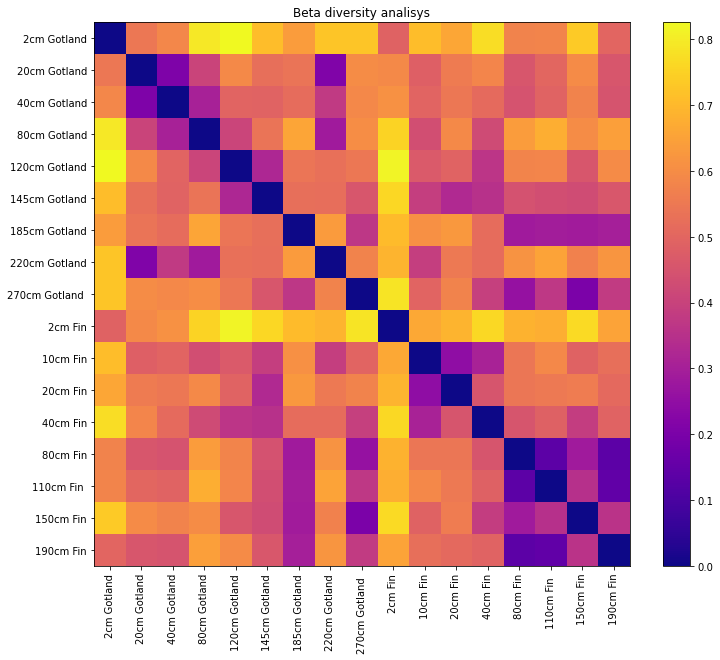

In [64]:
fig = dm.plot("plasma", "Beta diversity analisys")
fig.set_size_inches((12, 10))
plt.savefig("../figures/beta_braycurtis.png")

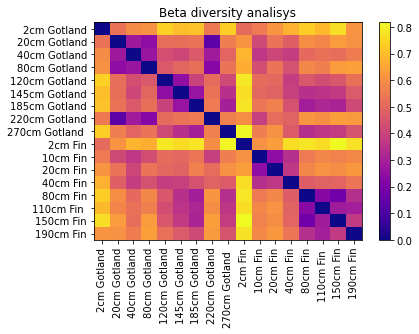

In [22]:
qiime_dm = pd.read_csv("../data/processed/beta_div_bray_curtis/bray_curtis_otu_table.txt", sep="\t", index_col=0)
fig = dm.plot("plasma", "Beta diversity analisys")

In [50]:
otu_names = list(map(lambda x: x.replace('_', " "), comp_otu.columns.values))
print(otu_names[:10])

['OTU 4', 'OTU 16', 'OTU 2', 'OTU 26', 'OTU 5', 'OTU 13', 'OTU 10', 'OTU 8', 'OTU 15', 'OTU 38']


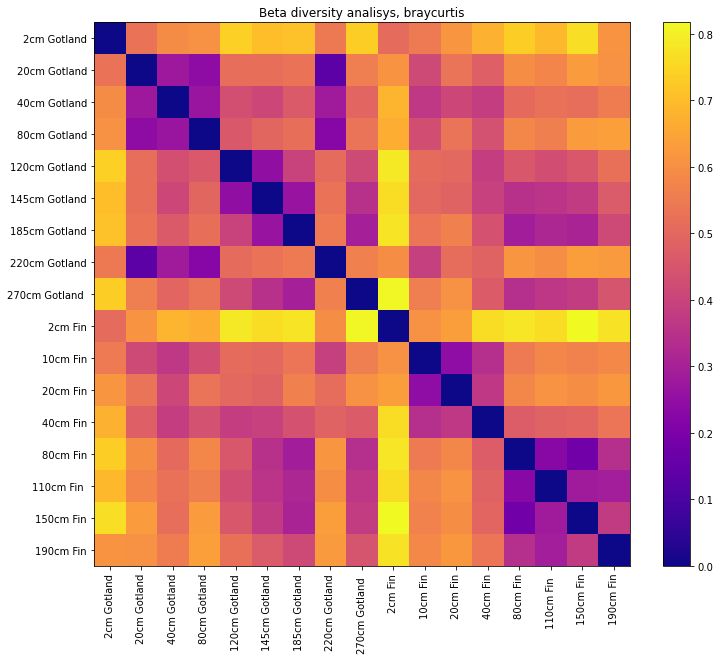

In [101]:
metrics = ["braycurtis", "unweighted_unifrac", "weighted_unifrac"]
metric = metrics[0]

if "unifrac" in metric:
    dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index, otu_ids=otu_names, tree=tree)
else:
    dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index)
    
fig = dm.plot("plasma", f"Beta diversity analisys, {metric}")
fig.set_size_inches((12, 10))
plt.savefig(f"../figures/beta_{metric}.png")

## NMDS

In [102]:
samples = comp_otu.index.values
metasamples = list(map(lambda x: x.split()[-1], samples))
depth = np.array(list(map(lambda x: int(x.split()[0][:-2]), samples)))
print(metasamples)
print(depth)

ms2ids = dict(zip(set(metasamples), range(len(set(metasamples)))))
ids2ms = {y: x for x, y in ms2ids.items()}
metasamples_ids = [ms2ids[x] for x in metasamples]

['Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin']
[  2  20  40  80 120 145 185 220 270   2  10  20  40  80 110 150 190]


(17, 1225)
(17, 2)


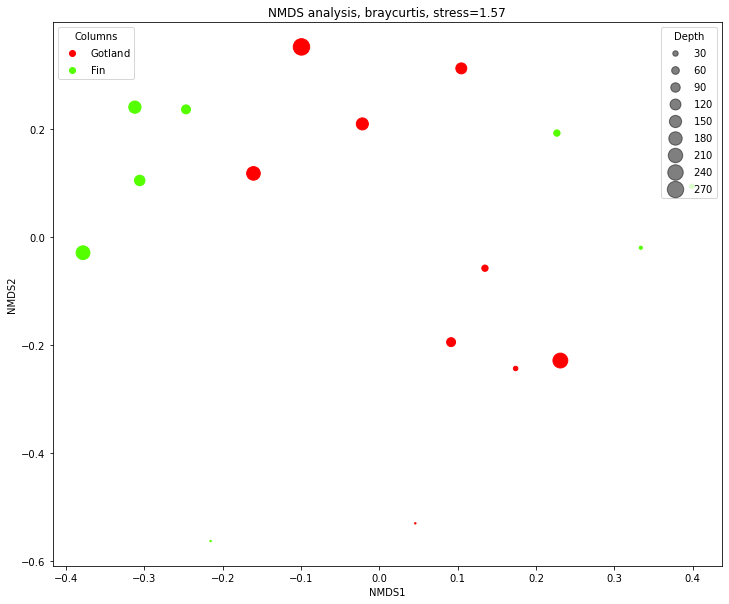

In [108]:
embedding = MDS(n_components=2, metric=True, n_jobs=-1, dissimilarity="precomputed")
X_transformed = embedding.fit_transform(dm.redundant_form())
print(X_transformed.shape)


# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=metasamples_ids, s=depth, cmap="prism")

# produce a legend with the unique colors from the scatter
handles0, labels0 = scatter.legend_elements()
labels0 = [re.sub("(\d)", lambda x: ids2ms[int(x.groups()[0])], labels0[0]), re.sub("(\d)", lambda x: ids2ms[int(x.groups()[0])], labels0[1])]

legend1 = ax.legend(handles0, labels0, loc="upper left", title="Columns")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
legend2 = ax.legend(handles, labels, loc="upper right", title="Depth")

plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.title(f"NMDS analysis, {metric}, stress={embedding.stress_:.2f}")
plt.savefig(f"../figures/NMDS_{metric}.png")
plt.show()

## Correlation analysis

In [2]:
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS

# import skbio
# from skbio import diversity
# from skbio.stats import ordination

In [3]:
comp_full = pd.read_csv("../data/processed/comp_full.csv")
comp_full["2cm Gotland"] = comp_full["2cm Gotland"].fillna(0.)
print(comp_full.shape)
comp_full.head()

(1225, 25)


,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [4]:
comp_melted = comp_full.melt(comp_full.columns[-8:], comp_full.columns[:-8], value_name="Share", var_name="Sample")
comp_melted["Depth"] = comp_melted.Sample.apply(lambda x: int(x.split()[0].strip("cm")))
comp_melted["Metasample"] = comp_melted.Sample.apply(lambda x: x.split()[1])
print(comp_melted.shape)
comp_melted.head()

(20825, 12)


,domain,phylum,class,order,family,genus,sequence,OTU,Sample,Share,Depth,Metasample
0,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4,2cm Gotland,10.46120,2,Gotland
1,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16,2cm Gotland,3.50275,2,Gotland
2,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2,2cm Gotland,4.32900,2,Gotland
3,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26,2cm Gotland,3.19500,2,Gotland
4,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5,2cm Gotland,2.78275,2,Gotland


In [5]:
comp_otu = pd.read_csv("../data/processed/otu_table.csv")
print(comp_otu.Samples.unique())
comp_otu.head()

['2cm Gotland' '20cm Gotland' '40cm Gotland' '80cm Gotland'
 '120cm Gotland' '145cm Gotland' '185cm Gotland' '220cm Gotland'
 '270cm Gotland ' '2cm Fin' '10cm Fin' '20cm Fin' '40cm Fin' '80cm Fin'
 '110cm Fin ' '150cm Fin' '190cm Fin']


,Samples,OTU_4,OTU_16,OTU_2,OTU_26,OTU_5,OTU_13,OTU_10,OTU_8,OTU_15,...,OTU_499,OTU_625,OTU_490,OTU_1248,OTU_532,OTU_737,OTU_794,OTU_620,OTU_671,OTU_581
0,2cm Gotland,10.46120,3.50275,4.32900,3.19500,2.78275,2.06635,3.24020,2.43050,2.64815,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0056,0.0056,0.0000,0.00000
1,20cm Gotland,1.11490,0.43230,15.87030,2.77590,1.77470,0.09100,0.09100,2.69620,1.16040,...,0.0000,0.0,0.0,0.00000,0.0,0.0114,0.0000,0.0000,0.0000,0.01140
2,40cm Gotland,1.00465,0.23410,12.43845,1.50360,3.42070,0.00000,0.00000,0.93655,0.88000,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0000,0.0000,0.0000,0.02730
3,80cm Gotland,0.54855,0.23175,16.66055,2.15655,0.80630,0.03775,0.00000,0.80560,0.32755,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0000,0.0000,0.0000,0.02670
4,120cm Gotland,0.29410,0.11385,1.42445,0.79220,0.64980,0.00665,0.00665,0.11005,0.50090,...,0.0185,0.0,0.0,0.00665,0.0,0.0000,0.0000,0.0000,0.0185,0.00665


In [6]:
metalls = pd.read_csv("../data/metalls.csv")
metalls = metalls.set_index("Sample")
metalls

,Depth,"Sr,mg/kg","Pb,mg/kg","As,mg/kg","Zn,mg/kg","Cu,mg/kg","Ni,mg/kg","Co,mg/kg","Fe2O3,%","MnO,mg/kg","Cr,mg/kg","V,mg/kg","TiO2,%"
Sample,,,,,,,,,,,,,
2cm Gotland,2,153.49,67.79,25.66,204.43,54.30,56.90,13.85,6.91,903.09,105.93,124.83,0.80
20cm Gotland,20,132.16,76.21,24.31,211.54,29.41,58.53,15.43,7.37,1238.55,101.57,119.64,0.81
40cm Gotland,40,166.99,55.55,17.49,142.11,72.92,63.19,20.86,8.18,1739.48,115.86,132.15,0.85
2cm Fin,2,198.22,13.51,20.73,146.27,62.81,55.44,24.47,8.85,3540.63,116.50,121.93,0.86
10cm Fin,10,206.30,21.78,12.76,147.55,66.72,55.70,23.35,9.27,2712.02,125.72,127.57,0.92
20cm Fin,20,207.27,16.81,11.71,147.67,67.36,56.61,23.72,7.97,1883.87,108.98,124.96,0.83
40cm Fin,40,215.84,15.10,12.84,149.96,69.19,57.17,20.74,7.75,1788.90,113.53,128.79,0.89


In [7]:
metan = pd.read_csv("../data/metan.csv")
metan = metan.set_index("Sample")
metan

,Depth,"Metan,mmol/l"
Sample,,
2cm Fin,2,0.002
10cm Fin,10,0.043
20cm Fin,20,0.132
40cm Fin,40,0.309
80cm Fin,80,4.024
110cm Fin,110,5.195
150cm Fin,150,3.524
190cm Fin,190,3.850
2cm Gotland,2,0.120


In [8]:
comp_melted_full = pd.merge(comp_melted, metan[["Metan,mmol/l"]], left_on="Sample", right_index=True)
comp_melted_full = pd.merge(comp_melted_full, metalls.drop("Depth", axis=1), left_on="Sample", right_index=True)
comp_melted_full.head()

,domain,phylum,class,order,family,genus,sequence,OTU,Sample,Share,...,"As,mg/kg","Zn,mg/kg","Cu,mg/kg","Ni,mg/kg","Co,mg/kg","Fe2O3,%","MnO,mg/kg","Cr,mg/kg","V,mg/kg","TiO2,%"
0,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4,2cm Gotland,10.46120,...,25.66,204.43,54.3,56.9,13.85,6.91,903.09,105.93,124.83,0.8
1,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16,2cm Gotland,3.50275,...,25.66,204.43,54.3,56.9,13.85,6.91,903.09,105.93,124.83,0.8
2,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2,2cm Gotland,4.32900,...,25.66,204.43,54.3,56.9,13.85,6.91,903.09,105.93,124.83,0.8
3,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26,2cm Gotland,3.19500,...,25.66,204.43,54.3,56.9,13.85,6.91,903.09,105.93,124.83,0.8
4,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5,2cm Gotland,2.78275,...,25.66,204.43,54.3,56.9,13.85,6.91,903.09,105.93,124.83,0.8


### Depth

In [7]:
phylums_significant = []
for i, ph in enumerate(comp_melted.groupby("phylum").Share.sum().sort_values(ascending=False).head(25).index):
    df = comp_melted[comp_melted.phylum == ph].groupby(["Metasample", "Depth"])["Share"].sum().reset_index()
    r, pval = scipy.stats.pearsonr(df.Depth.values, df.Share.values)
    if pval < 0.06:
        print(f"{ph}, r={r:.2f}, pval={pval:.3f}")
        phylums_significant.append(ph)
        
print(len(phylums_significant))

Planctomycetota, r=0.48, pval=0.052
Caldatribacteriota, r=0.57, pval=0.018
Desulfobacterota, r=-0.56, pval=0.021
Acidobacteriota, r=0.58, pval=0.014
Bacteroidota, r=-0.55, pval=0.021
Verrucomicrobiota, r=-0.60, pval=0.010
Myxococcota, r=-0.52, pval=0.031
7


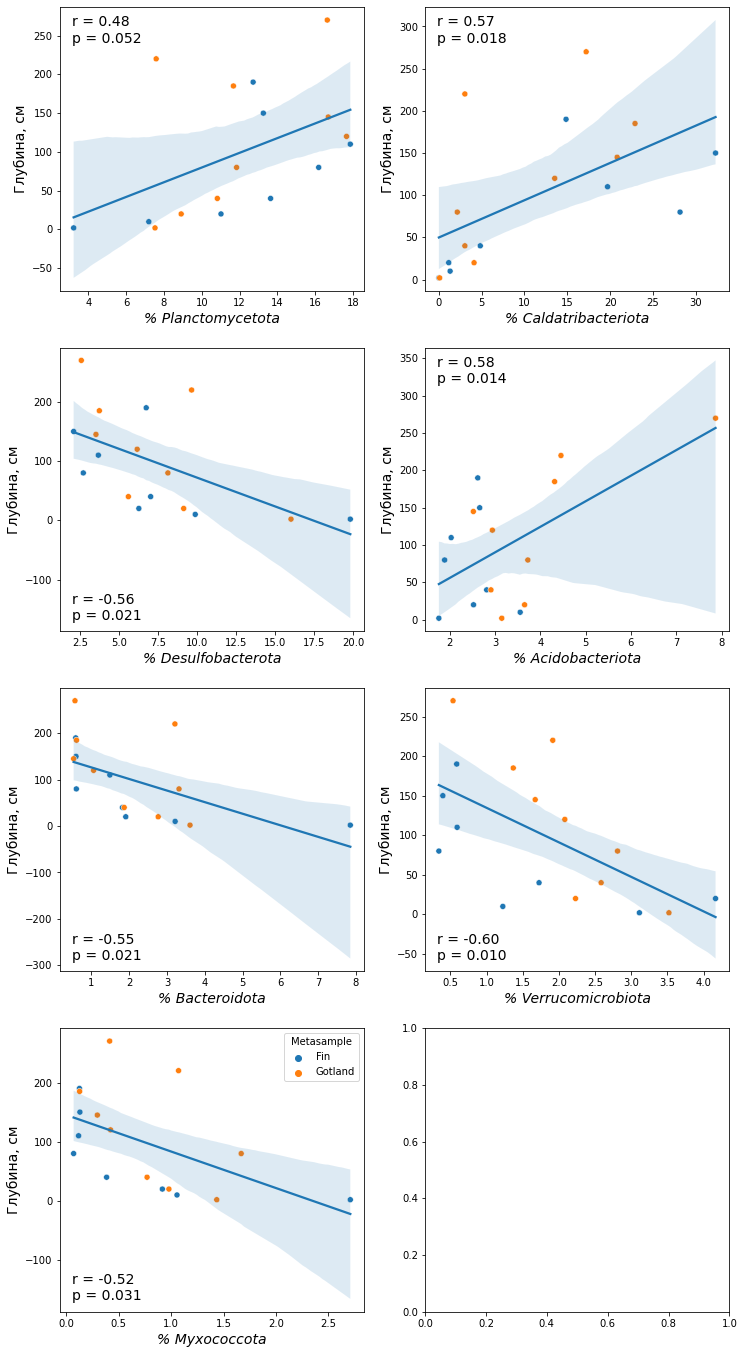

In [194]:
# phylums = ["Desulfobacterota", "Planctomycetota", "Bacteroidota", "Verrucomicrobiota", "Acidobacteriota", ]

nrows, ncols = 4, 2
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches((12, 24))
legend=False
for i, ph in enumerate(phylums_significant):
    if i == 6:
        legend=True
    df = comp_melted[comp_melted.phylum == ph].groupby(["Metasample", "Depth"])["Share"].sum().reset_index()
    cax = axs[i // ncols, i % ncols]
    sns.scatterplot(x="Share", y="Depth", hue="Metasample", data=df, legend=legend, ax=cax)
    sns.regplot(x="Share", y="Depth", data=df, scatter=False, ax=cax)
    r, pval = scipy.stats.pearsonr(df.Depth.values, df.Share.values)
    # cax.set_title(f"{ph}, r={r:.2f}, pval={pval:.3f}")
    cax.set_xlabel(f"% {ph}", fontsize=14, fontstyle="italic")
    cax.set_ylabel("Глубина, см", fontsize=14)
    
    left, right = cax.get_xbound()
    bottom, top = cax.get_ybound()

    if ph in ["Planctomycetota", "Caldatribacteriota", "Acidobacteriota"]:
        cax.text(
            left + (right - left) / 25, 
            top - (top - bottom) / 8, 
            f"r = {r:.2f}\np = {pval:.3f}",
            fontsize=14
        )
    else:
        cax.text(
            left + (right - left) / 25, 
            bottom + (top - bottom) / 25, 
            f"r = {r:.2f}\np = {pval:.3f}",
            fontsize=14
        )

plt.savefig("../figures/correlation_depth_vs_abundance.png", dpi=100)
plt.show()

### Metan

In [178]:
phylums_significant = []
for i, ph in enumerate(comp_melted_full.groupby("phylum").Share.sum().sort_values(ascending=False).head(25).index):
    df = comp_melted_full[comp_melted_full.phylum == ph].groupby(["Metasample", "Metan,mmol/l"])["Share"].sum().reset_index()
    r, pval = scipy.stats.pearsonr(df["Metan,mmol/l"].values, df.Share.values)
    if pval < 0.06:
        print(f"{ph}, r={r:.2f}, pval={pval:.3f}")
        phylums_significant.append(ph)
        
print(len(phylums_significant))

Actinobacteriota, r=-0.75, pval=0.050
Chloroflexi, r=0.91, pval=0.005
Latescibacterota, r=0.80, pval=0.031
Spirochaetota, r=0.95, pval=0.001
4


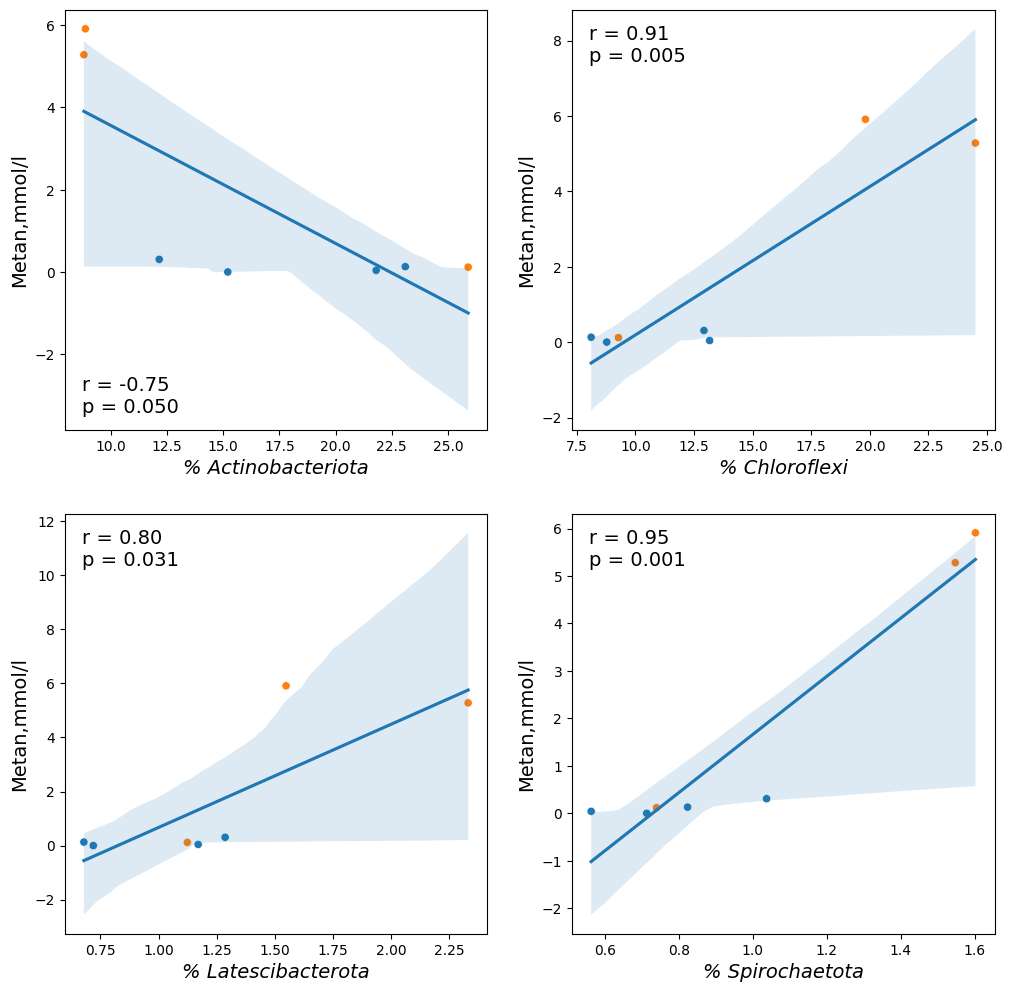

In [180]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches((12, 12))
legend=False
for i, ph in enumerate(phylums_significant):
    if i == 6:
        legend=True
    df = comp_melted_full[comp_melted_full.phylum == ph].groupby(["Metasample", "Metan,mmol/l"])["Share"].sum().reset_index()
    cax = axs[i // ncols, i % ncols]
    sns.scatterplot(x="Share", y="Metan,mmol/l", hue="Metasample", data=df, legend=legend, ax=cax)
    sns.regplot(x="Share", y="Metan,mmol/l", data=df, scatter=False, ax=cax)
    r, pval = scipy.stats.pearsonr(df["Metan,mmol/l"].values, df.Share.values)
    # cax.set_title(f"{ph}, r={r:.2f}, pval={pval:.3f}")
    cax.set_xlabel(f"% {ph}", fontsize=14, fontstyle="italic")
    cax.set_ylabel("Metan,mmol/l", fontsize=14)
    
    left, right = cax.get_xbound()
    bottom, top = cax.get_ybound()

    if ph in ["Actinobacteriota"]:
        cax.text(
            left + (right - left) / 25, 
            bottom + (top - bottom) / 25, 
            f"r = {r:.2f}\np = {pval:.3f}",
            fontsize=14
        )
    else:
        cax.text(
            left + (right - left) / 25, 
            top - (top - bottom) / 8, 
            f"r = {r:.2f}\np = {pval:.3f}",
            fontsize=14
        )

plt.savefig("../figures/correlation_Metan_vs_abundance.png", dpi=100)
plt.show()

### In-depth correlations

In [101]:
comp_otu_sample = comp_otu.set_index("Samples")
comp_otu_sample = comp_otu_sample[comp_otu_sample.sum(axis=0)[comp_otu_sample.sum(axis=0) > .5].index]
comp_otu_sample.shape

(17, 235)

In [110]:
cor_df = pd.DataFrame(index=comp_otu_sample.columns)

cor_df["Metan,mmol/l"] = comp_otu_sample.corrwith(metan["Metan,mmol/l"])
for c in metalls.columns[1:]:
    cor_df[c] = comp_otu_sample.corrwith(metalls[c])
cor_df = cor_df.dropna()
cor_df = cor_df[(cor_df.min(axis=1) < -0.5) | (cor_df.max(axis=1) > 0.5)]
cor_df.shape

(215, 13)

In [113]:
tnum = 3
otu2taxa = comp_melted.set_index("OTU").apply(lambda x: " | ".join(x.iloc[1:tnum+1].fillna("")), axis=1).to_dict()
# cor_df.index = cor_df.index.map(otu2taxa)

In [111]:
cor_df

,"Metan,mmol/l","Sr,mg/kg","Pb,mg/kg","As,mg/kg","Zn,mg/kg","Cu,mg/kg","Ni,mg/kg","Co,mg/kg","Fe2O3,%","MnO,mg/kg","Cr,mg/kg","V,mg/kg","TiO2,%"
OTU_4,0.033479,-0.430687,0.469897,0.666945,0.583969,-0.208726,-0.151331,-0.646437,-0.559444,-0.428419,-0.367993,-0.178562,-0.564729
OTU_16,-0.240339,-0.395932,0.463892,0.579767,0.604628,-0.206718,-0.179333,-0.674478,-0.597926,-0.516518,-0.376809,-0.139660,-0.534133
OTU_2,0.535824,-0.808175,0.783614,0.486470,0.460049,-0.593875,0.691859,-0.485650,-0.236150,-0.383239,-0.347081,-0.115122,-0.342417
OTU_5,-0.159652,0.692860,-0.571245,-0.887074,-0.530548,0.583281,-0.179920,0.484429,0.239616,0.019152,0.344620,0.466306,0.427996
OTU_13,-0.494086,0.063443,-0.214152,0.430603,-0.013901,0.001990,-0.466027,0.161691,0.183628,0.544854,0.061919,-0.446059,-0.141865
...,...,...,...,...,...,...,...,...,...,...,...,...,...
OTU_159,0.001046,0.198616,-0.099405,-0.411167,-0.164186,0.079645,-0.004333,0.122005,0.444019,0.105609,0.576622,0.352194,0.738101
OTU_492,0.090966,0.423400,-0.287275,-0.571143,-0.399419,0.452532,0.298685,0.134189,-0.029509,-0.153255,0.225653,0.676290,0.496210
OTU_548,0.248342,0.249851,-0.173749,-0.419728,-0.368538,0.348975,0.510245,0.121516,-0.156258,-0.182828,-0.024904,0.548365,0.210115
OTU_558,0.276826,0.230451,-0.080151,-0.570129,-0.322694,0.331664,0.501526,0.070002,-0.008485,-0.276762,0.202341,0.702186,0.441028


In [93]:
# g.dendrogram_row.reordered_ind

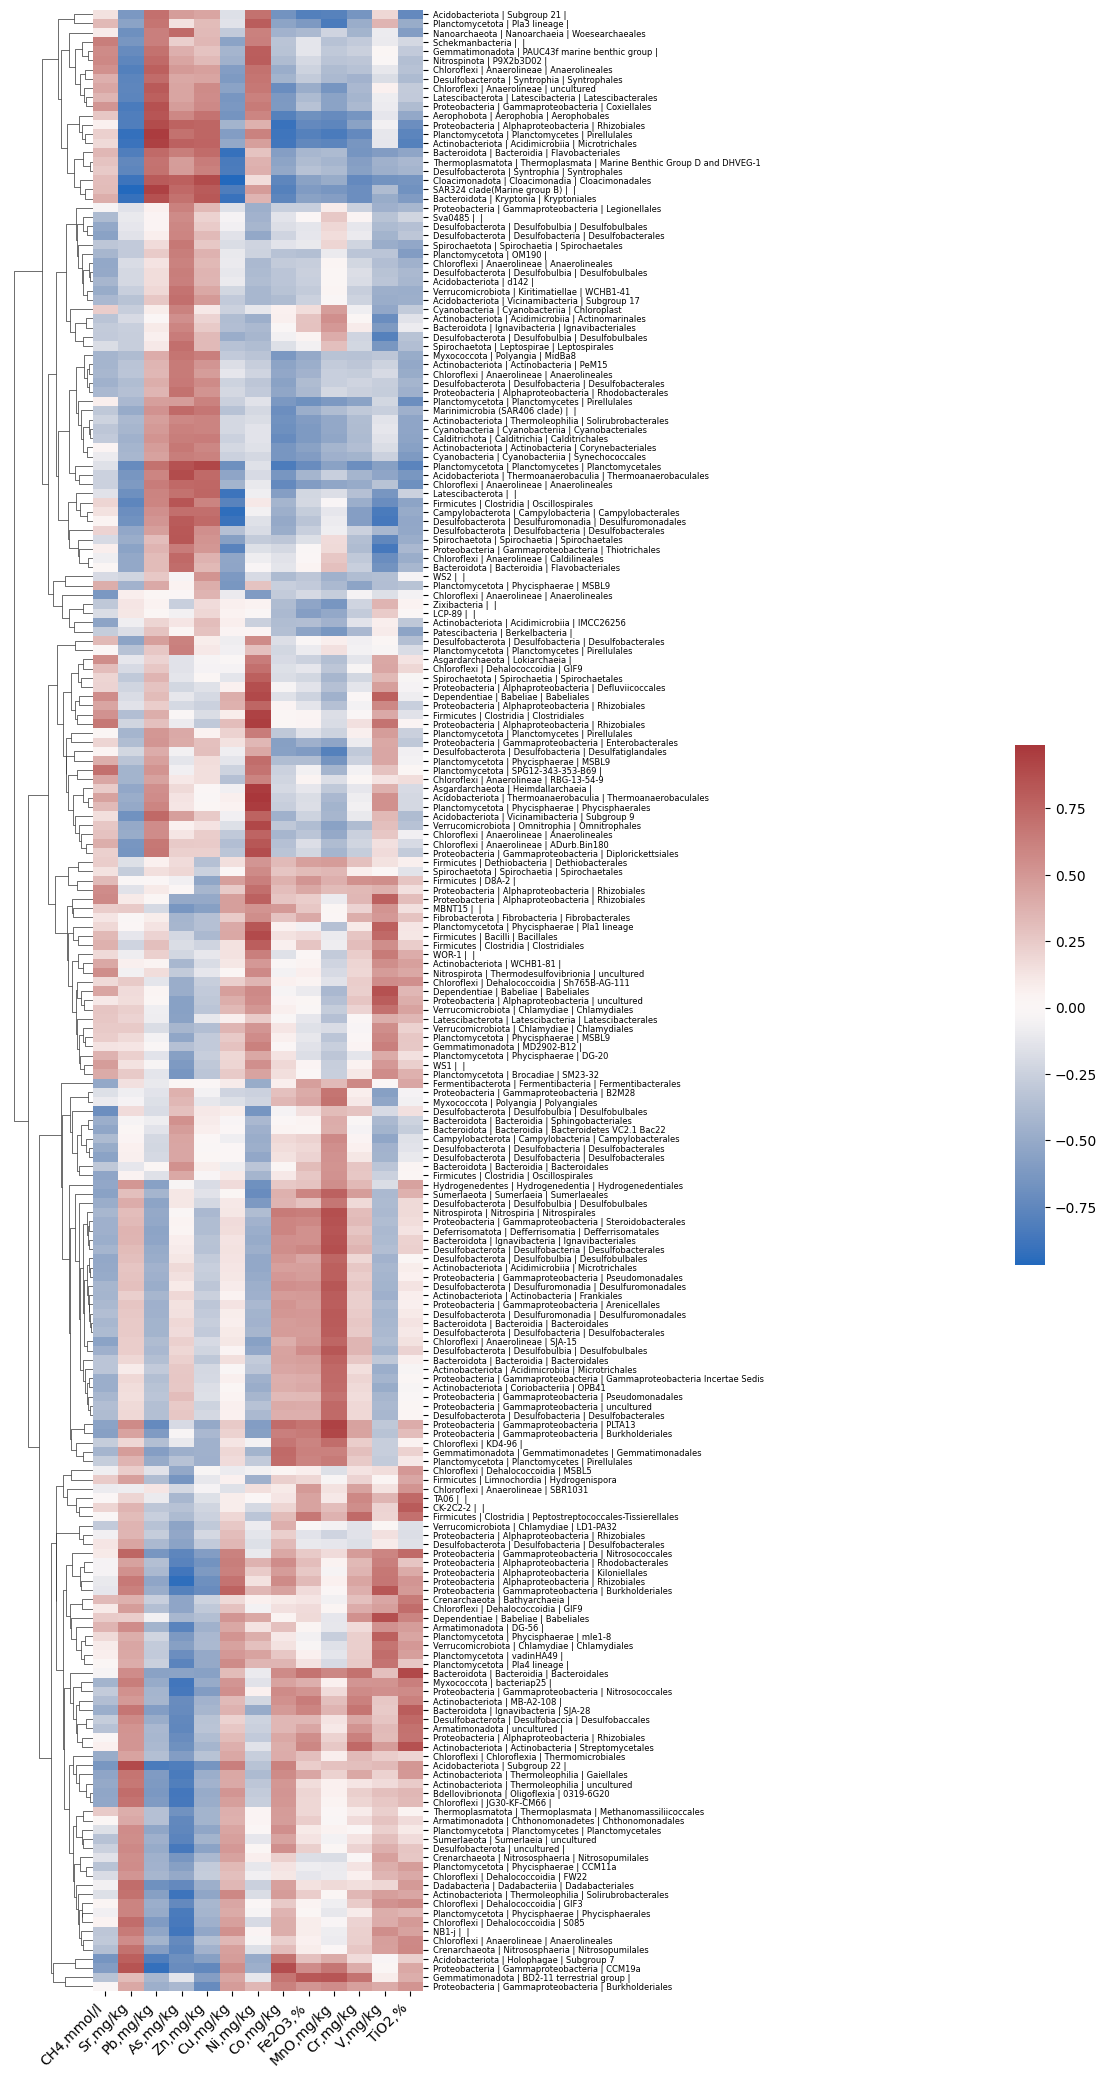

In [116]:
g = sns.clustermap(
    cor_df.rename(columns={"Metan,mmol/l": "CH4,mmol/l"}), 
    cmap="vlag", 
    col_cluster=False,  # row_cluster=False,
    cbar_pos=(1.02, .32, .03, .2),
    figsize=(10, 26),
    # yticklabels=cor_df.index.values,
    yticklabels=cor_df.index.map(otu2taxa).values
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(g.ax_heatmap.get_yticklabels(), size=6,)
g.ax_col_dendrogram.remove()

g.savefig("../figures/chem_corr.png")

In [124]:
tnum = 5
otu2taxa = comp_melted.set_index("OTU").apply(lambda x: " | ".join(x.iloc[1:tnum+1].fillna("")), axis=1).to_dict()

In [158]:
comp_full.iloc[:, -8:].drop("sequence", axis=1)\
    .merge(cor_df["Metan,mmol/l"].reset_index().rename(columns={"index": "OTU"}), on="OTU", how="right")\
        .sort_values("Metan,mmol/l")\
            .dropna(subset="Metan,mmol/l")\
                .tail(20)

,domain,phylum,class,order,family,genus,OTU,"Metan,mmol/l"
65,Bacteria,Actinobacteriota,WCHB1-81,NaN,NaN,NaN,OTU_61,0.418421
25,Bacteria,Chloroflexi,Anaerolineae,uncultured,NaN,NaN,OTU_97,0.423853
176,Bacteria,Chloroflexi,Anaerolineae,RBG-13-54-9,NaN,NaN,OTU_237,0.428717
66,Bacteria,Dependentiae,Babeliae,Babeliales,Vermiphilaceae,NaN,OTU_283,0.434006
132,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Filomicrobium,OTU_146,0.436442
105,Bacteria,Acidobacteriota,Thermoanaerobaculia,Thermoanaerobaculales,Thermoanaerobaculaceae,Subgroup 10,OTU_90,0.451693
120,Bacteria,WS1,NaN,NaN,NaN,NaN,OTU_198,0.475347
77,Bacteria,Proteobacteria,Gammaproteobacteria,Coxiellales,Coxiellaceae,Coxiella,OTU_209,0.514343
190,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium sensu stricto 1,OTU_255,0.528256
2,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,OTU_2,0.535824


## JS1 group
It's "OTU_1"

In [172]:
comp_full[comp_full["class"] == "JS1"]

,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
205,0.101,4.1183,3.0466,2.16265,13.5264,20.8115,22.8959,3.0452,17.19455,0.0126,...,32.29125,14.8494,Bacteria,Caldatribacteriota,JS1,NaN,NaN,NaN,TACATAAGGAGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCT...,OTU_1


In [181]:
_comp_otu_sample = comp_otu.set_index("Samples")
_comp_otu_sample = _comp_otu_sample[["OTU_1"]]
_comp_otu_sample.shape

(17, 1)

In [185]:
_cor_df_js1 = pd.DataFrame(index=_comp_otu_sample.columns)

_cor_df_js1["Metan,mmol/l"] = _comp_otu_sample.corrwith(metan["Metan,mmol/l"])
for c in metalls.columns[1:]:
    _cor_df_js1[c] = _comp_otu_sample.corrwith(metalls[c])
_cor_df_js1 = _cor_df_js1.dropna()
_cor_df_js1.rename(index={"OTU_1": "JS 1"})

,"Metan,mmol/l","Sr,mg/kg","Pb,mg/kg","As,mg/kg","Zn,mg/kg","Cu,mg/kg","Ni,mg/kg","Co,mg/kg","Fe2O3,%","MnO,mg/kg","Cr,mg/kg","V,mg/kg","TiO2,%"
JS 1,0.349015,-0.11118,0.173277,-0.194237,0.060203,-0.179155,0.46682,-0.196209,-0.247032,-0.370739,-0.198289,0.229354,0.146066


## Metalls self-correlation

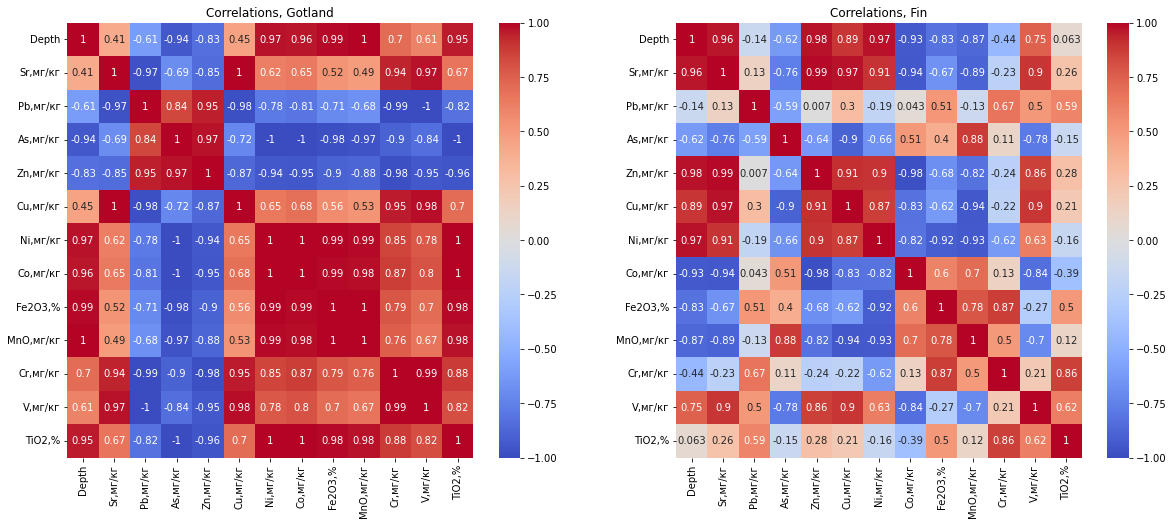

In [7]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 8))
axs[0].set_title("Correlations, Gotland")
sns.heatmap(metalls.iloc[:3].corr(), vmin=-1, vmax=1, annot=True, ax=axs[0], cmap="coolwarm")

axs[1].set_title("Correlations, Fin")
sns.heatmap(metalls.iloc[3:].corr(), vmin=-1, vmax=1, annot=True, ax=axs[1], cmap="coolwarm")
plt.savefig("../figures/metalls_corr", dpi=100)
plt.show()

## Tree visualization

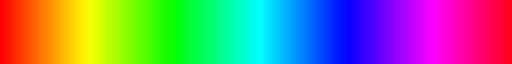

In [8]:
plt.cm.hsv

In [13]:
df = comp_full[["OTU", "phylum"]]

ph2color = {ph: matplotlib.colors.to_hex(plt.cm.hsv(i / df.phylum.nunique())) for i, ph in enumerate(df.phylum.unique(), 1)}
ph2color

{'Actinobacteriota': '#ff1200',
 'Chloroflexi': '#ff2300',
 'Desulfobacterota': '#ff3500',
 'Cyanobacteria': '#ff4700',
 'Planctomycetota': '#ff5900',
 'Verrucomicrobiota': '#ff6a00',
 'Proteobacteria': '#ff7c00',
 'Acidobacteriota': '#ff8e00',
 'Bacteroidota': '#ff9f00',
 'Sva0485': '#ffb100',
 'Latescibacterota': '#ffc300',
 'Calditrichota': '#ffd500',
 'NB1-j': '#ffe600',
 'Campylobacterota': '#fcf500',
 'Zixibacteria': '#f4ff00',
 'Myxococcota': '#e2ff00',
 'Nanoarchaeota': '#d1ff00',
 'Dependentiae': '#bfff00',
 'Firmicutes': '#adff00',
 'Gemmatimonadota': '#9cff00',
 'MBNT15': '#84ff00',
 'NKB15': '#72ff00',
 'SAR324 clade(Marine group B)': '#61ff00',
 'Spirochaetota': '#4fff00',
 'WS2': '#3dff00',
 'Marinimicrobia (SAR406 clade)': '#2bff00',
 'Hydrogenedentes': '#1aff00',
 'Modulibacteria': '#08ff00',
 'Nitrospirota': '#02ff0c',
 'Patescibacteria': '#00ff1b',
 'Bdellovibrionota': '#00ff2d',
 'Elusimicrobiota': '#00ff3f',
 'Fermentibacterota': '#00ff51',
 'LCP-89': '#00ff62',
 'M

In [15]:
"""
TREE_COLORS
SEPARATOR TAB
DATA
"""

df = comp_full[["OTU", "phylum"]]
df["type"] = "label_background"
ph2color = {ph: matplotlib.colors.to_hex(plt.cm.hsv(i / df.phylum.nunique())) for i, ph in enumerate(df.phylum.unique(), 1)}
df["color"] = df.phylum.map(ph2color)
# df["style"] = "bold-italic"
# df["size_factor"] = 1
# df["rotation"] = 0

df = df["OTU type color".split()]
df.to_csv("../data/processed/tree_colors.txt", index=None, header=None, sep="\t")

/tmp/ipykernel_9472/3726589636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = "label_background"
/tmp/ipykernel_9472/3726589636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"] = df.phylum.map(ph2color)


In [ ]:
"""
DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,example text dataset
COLOR,#ff0000
DATA
"""
#ID,label,position,color,style,size_factor,rotation

df = comp_full[["OTU", "phylum"]]
df["position"] = -1
ph2color = {ph: matplotlib.colors.to_hex(plt.cm.coolwarm(i / df["phylum"].nunique())) for i, ph in enumerate(df["phylum"].unique(), 1)}
df["color"] = df["phylum"].map(ph2color)
df["style"] = "bold-italic"
df["size_factor"] = 2.5
df["rotation"] = 0

df.to_csv("../data/processed/tree_labels.txt", index=None, header=None)

In [37]:
import re
import warnings
warnings.filterwarnings("ignore")

In [114]:
with open("../data/processed/phylo.treefile.rooted") as fin:
    tree_str = fin.read()

df = comp_full[["OTU", "domain", "phylum", "class"]]
df["taxa"] = df.OTU + "_" + df.phylum + "_" + df["class"].str.replace("\W+", "_")

otu2taxa = df.dropna().set_index("OTU")["taxa"].to_dict()

In [115]:
tree_str_taxa = re.sub("(OTU_\d{1,4}):", lambda x: otu2taxa.get(x.group(1), x.group(1)) + ":", tree_str)

In [116]:
with open("../data/processed/phylo.treefile.rooted.taxa", "w") as fout:
    fout.write(tree_str_taxa)

In [117]:
"""
TREE_COLORS
SEPARATOR TAB
DATA
"""

df["type"] = "label"
ph2color = {ph: matplotlib.colors.to_hex(plt.cm.hsv(i / df.phylum.nunique())) for i, ph in enumerate(df.phylum.unique(), 1)}
df["color"] = df.phylum.map(ph2color)

df["taxa type color".split()].to_csv("../data/processed/tree_colors.txt", index=None, header=None, sep="\t")

In [84]:
from ete3 import PhyloTree

In [135]:
dom = "Bacteria"  # Archaea

tree = PhyloTree("../data/processed/phylo.treefile.rooted.taxa", format=0)
tree.prune(df[df.domain == dom].taxa.dropna().values)
tree.write(outfile=f"../data/processed/tree.{dom}.nwk")

In [128]:
tree.write("")

Number of leaf nodes:	1146
Total number of nodes:	2291
Rooted:	Yes
Most distant node:	OTU_719_Planctomycetota_Phycisphaerae
Max. distance:	1.522333
